In [1]:
import pandas as pd
import datetime
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api         as sm
import statsmodels.formula.api as smf
from scipy.interpolate import interp1d


Lectura de la sabana de datos

In [2]:
# read file
path = "data/"
file = "sabana_outer_21_07_2020_v1_DF.csv"
#file = "sabana_outer_v3_DF.csv"
df=pd.read_csv(path + file)
df = df.astype('category')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (17,20,29,93,217) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
cols = df.columns

#df.columns[pd.Series(df.columns).str.startswith('medicamento')]
cols

Index(['fecha_consulta', 'sexo_paciente', 'fecha_nacimiento',
       'diagnostico_principal', 'imc', 'fecha2', 'bsa',
       'calidad de vida relacionada en salud', 'dlqi', 'easi',
       ...
       'pasi -> entre 10-15',
       'sindrome metabolico -> presencia de sindrome metabolico complet',
       'terapia biologica -> medicamento que requiere ajuste de dosis p',
       'terapia biologica -> tratamiento activo',
       'terapia sistematica previa -> tratamiento previo con fallo tera',
       'terapia sistemica de primera linea -> tratamiento activo', 'id', 'ano',
       'mes', 'dia'],
      dtype='object', length=260)

In [4]:
df["fecha_consulta"] = pd.to_datetime(df['fecha_consulta'])
df["fecha_nacimiento"] = pd.to_datetime(df['fecha_nacimiento'])

df["id"] = df["id"].astype('Int64')
df["dia"] = df["dia"].astype('Int64')
df["mes"] = df["mes"].astype('Int64')
df["ano"] = df["ano"].astype('Int64')
df["pasi"] = df["pasi"].astype('float')
df["edad"] = round(df["ano"]- pd.DatetimeIndex(df["fecha_nacimiento"]).year,0)
print(df.shape)
df.sample(5)

(18408, 261)


,fecha_consulta,sexo_paciente,fecha_nacimiento,diagnostico_principal,imc,fecha2,bsa,calidad de vida relacionada en salud,dlqi,easi,...,sindrome metabolico -> presencia de sindrome metabolico complet,terapia biologica -> medicamento que requiere ajuste de dosis p,terapia biologica -> tratamiento activo,terapia sistematica previa -> tratamiento previo con fallo tera,terapia sistemica de primera linea -> tratamiento activo,id,ano,mes,dia,edad
4813,NaT,NaN,NaT,NaN,NaN,2018-12-14,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2693178,2018,12,14,NaN
11035,2020-02-10,f,1972-04-04,l400,21.6,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1637712,2020,2,10,48.0
18258,2019-11-15,f,1997-11-24,l400,21.3,2019-11-15,NaN,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,529102,2019,11,15,22.0
4552,2019-02-20,m,1989-11-01,l400,34.6,2019-02-20,81.0,70.0,19.0,NaN,...,NaN,NaN,NaN,NaN,NaN,2727256,2019,2,20,30.0
14742,2018-06-23,m,1989-09-20,l400,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1090380,2018,6,23,29.0


In [5]:
ids = df["id"].unique()#los id en el dataset
df.columns = df.columns.str.replace("/", "__")
df.columns = df.columns.str.replace(" ", "_")
df.columns = df.columns.str.replace("+", "_con_")
df.columns = df.columns.str.replace("-", "_")
df.columns = df.columns.str.replace(">", "A_")
df.columns = df.columns.str.replace("<", "_A")
df["ano_dec"] = df["ano"]+(1/12)*df["mes"] + (1/365)*df["dia"]
cols = df.columns# las variables medidas
col_num = ["dlqi","pga", "imc", "bsa", "edad", "depresion_total", "ansiedad_total" , "trastorno_sexual_total", "psi_total"]
col_med = cols[pd.Series(cols).str.startswith('medicamento')]
med_interes = ["adalimumab", "certolizumab","etanercept", "golimumab", "guselkumab",
               "infliximab", "ixekinumab", "secukinumab", "ustekinumab"]
varsX = []
for c in cols:
    if c in col_num:
        df[c] = df[c].astype('float')
        varsX.append(c)
    if c in col_med:
        if any(substring in c for substring in med_interes):
            varsX.append(c)
varsX.append('eritema')
varsX.append('endurecimiento')
varsX.append('descamacion')
varsX


['imc',
 'bsa',
 'dlqi',
 'pga',
 'depresion_total',
 'ansiedad_total',
 'trastorno_sexual_total',
 'psi_total',
 'medicamento_adalimumab',
 'medicamento_certolizumab',
 'medicamento_etanercept',
 'medicamento_golimumab',
 'medicamento_guselkumab',
 'medicamento_infliximab',
 'medicamento_ixekinumab',
 'medicamento_secukinumab',
 'medicamento_ustekinumab',
 'edad',
 'eritema',
 'endurecimiento',
 'descamacion']

version decimal de la fecha.. ano.decimal

In [6]:
varsY = ["pasi"]

In [7]:
#df.interpolate(method='linear', limit_direction='forward', axis=0)


df2 tiene solamente los datos de las columnas seleccionadas

In [8]:
sel = ["id","ano","mes","dia","sexo_paciente"]
for v in varsX:
    sel.append(v)
    print(v)
    print(df[v].unique())
for v in varsY:
    sel.append(v)

df2 = df[sel]


imc
[  26.7                  nan   23.6          23.           21.5
   23.2          25.3          26.6          25.6          24.2
   24.8          25.4          26.4          27.1          92.3
   32.7          33.05         35.3          34.9          35.1
   36.2          35.6          35.5          34.7          34.2
   24.9          24.4          24.7          25.2          26.
   27.4          23.7          32.5          32.3          32.
   33.3          32.9          34.           33.1          31.4
   28.8          31.2          28.9          35.9          35.45
   36.           29.           28.2          27.9          24.6
   29.1          28.7          29.5          28.3          29.8
   29.7          28.35         29.3          30.1          29.4
   28.6          27.8          25.7          27.3          25.9
   27.           26.3          31.5          30.3          32.1
   31.1          30.           30.8          29.2          29.95
   29.9          30.75         31.6 

| variable                   | tipo | valores                                                 |
|----------------------------|------|---------------------------------------------------------|
| dlqi                       | num  | numeros                                                 |
| imc                        | num  | numeros                                                 |
| bsa                        | num  | numeros                                                 |
| edad                       | num  | numeros                                                 |
| depresion_total (*)        | num  | numeros                                                 |
| ansiedad_total  (*)        | num  | numeros                                                 |
| trastorno_sexual_total (*) | num  | numeros                                                 |
| psi_total                  | num  | numeros                                                 |
| eritema                    | cat  | 0 1 2 3 4 5                                             |
| endurecimiento             | cat  | 0 1 2 3 4 5                                             |
| descamacion                | cat  | 0 1 2 3 4 5                                             |
| pga                        | cat  | 0 1 2 3 4 5                                             |
| sexo_paciente              | cat  | f m                                                     |
| medicamento_XXXX           | cat  | 0 1                                                     |
| area   XXXXXX              | cat  | 0 '<10%' '10-29%' '30-49%'  '50-69%' '70-89%' '90-100%' |
| sindrome metabolico        | cat  | si no                                                   |
| terapia xxxxx -> yyyy      | cat  | si no                                                   |

- df3_0 tienen los datos interpolados de las columnas seleccionadas en el instante k.
- df3_1 tienen los datos interpolados de las columnas seleccionadas en el instante k-1.
- df4 tiene a df3_0 y df3_1 así como la estimación de cambio de pasi

In [9]:
df2.sort_values(by=["ano","mes","dia"],inplace = True)

df3_0 = df2[df2["id"]==ids[0]].reset_index().fillna( method ='ffill')

df3_1 = df3_0.shift(periods=1)

for id in ids[1:]:
    df2_id = df2[df2["id"]==id].reset_index().fillna( method ='ffill')
    df3_0 = pd.concat([df3_0, df2_id],
                      axis=0, join='outer', ignore_index=False)
    df3_1 = pd.concat([df3_1, df2_id.shift(periods=1)], 
                      axis=0, join='outer', ignore_index=False)

    #df3_0 = df3_0.append(df2_id, ignore_index=True)
    #df3_1 = df3_1.append(df2_id.shift(periods=1), ignore_index=True)
df3_0.drop('index', axis=1, inplace=True)
df3_1.drop('index', axis=1, inplace=True)

for c in cols:
    df3_1.rename(columns={c : c + "_1"}, inplace = True)
df3_1.columns
df3_1.drop('id_1', axis=1, inplace=True)
df3_1.drop('sexo_paciente_1', axis=1, inplace=True)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [10]:
df3_1.columns

Index(['ano_1', 'mes_1', 'dia_1', 'imc_1', 'bsa_1', 'dlqi_1', 'pga_1',
       'depresion_total_1', 'ansiedad_total_1', 'trastorno_sexual_total_1',
       'psi_total_1', 'medicamento_adalimumab_1', 'medicamento_certolizumab_1',
       'medicamento_etanercept_1', 'medicamento_golimumab_1',
       'medicamento_guselkumab_1', 'medicamento_infliximab_1',
       'medicamento_ixekinumab_1', 'medicamento_secukinumab_1',
       'medicamento_ustekinumab_1', 'edad_1', 'eritema_1', 'endurecimiento_1',
       'descamacion_1', 'pasi_1'],
      dtype='object')

In [11]:
df4 = pd.concat([df3_0, df3_1], axis=1)

df4["fecha_dec"] =   df4["ano"]   + (1/12)*df4["mes"]   + (1/365)*df4["dia"]
df4["fecha_dec_1"] = df4["ano_1"] + (1/12)*df4["mes_1"] + (1/365)*df4["dia_1"]
df4["meses_desde_consulta"] = 12*(df4["fecha_dec"] - df4["fecha_dec_1"]) 

df4["dpasi"] = df4["pasi"] - df4["pasi_1"]
df4["dpasi_mes"] = df4["dpasi"] / df4["meses_desde_consulta"] 




In [39]:
df5 = df4.drop('pasi', axis=1).merge(df[['id', 'ano', 'mes', 'dia', 'pasi']], how = 'left',
                on = ['id', 'ano', 'mes', 'dia'])

In [47]:
df5[df5["id"]==3499725][["id","ano","mes","dia","pasi_1","pasi","dpasi"]]

,id,ano,mes,dia,pasi_1,pasi,dpasi
1,3499725,2013,5,2,NaN,NaN,NaN
2,3499725,2013,7,29,NaN,NaN,NaN
3,3499725,2018,7,27,NaN,0.4,NaN
4,3499725,2018,10,24,0.4,NaN,0.0
5,3499725,2019,5,24,0.4,0.0,-0.4
6,3499725,2019,6,19,0.0,NaN,0.0
7,3499725,2019,7,9,0.0,NaN,0.0
8,3499725,2019,11,14,0.0,NaN,0.0
9,3499725,2019,12,9,0.0,0.2,0.2
10,3499725,2020,1,20,0.2,NaN,0.0


In [48]:
df4[df4["id"]==3499725][["id","ano","mes","dia","pasi_1","pasi","dpasi_mes","dlqi","bsa","psi_total","imc"]]

,id,ano,mes,dia,pasi_1,pasi,dpasi_mes,dlqi,bsa,psi_total,imc
0,3499725,2013,5,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3499725,2013,7,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3499725,2018,7,27,NaN,0.4,NaN,1.0,NaN,NaN,23.2
3,3499725,2018,10,24,0.4,0.4,0.000000,1.0,NaN,NaN,23.2
4,3499725,2019,5,24,0.4,0.0,-0.057143,1.0,0.0,0.0,21.5
5,3499725,2019,6,19,0.0,0.0,0.000000,1.0,0.0,0.0,23.2
6,3499725,2019,7,9,0.0,0.0,0.000000,1.0,0.0,0.0,21.5
7,3499725,2019,11,14,0.0,0.0,0.000000,1.0,0.0,0.0,21.5
8,3499725,2019,12,9,0.0,0.2,0.239344,1.0,1.0,0.0,23.0
9,3499725,2020,1,20,0.2,0.2,0.000000,1.0,1.0,0.0,23.6


In [49]:
for c in df5.columns:
    print(c)

id
ano
mes
dia
sexo_paciente
imc
bsa
dlqi
pga
depresion_total
ansiedad_total
trastorno_sexual_total
psi_total
medicamento_adalimumab
medicamento_certolizumab
medicamento_etanercept
medicamento_golimumab
medicamento_guselkumab
medicamento_infliximab
medicamento_ixekinumab
medicamento_secukinumab
medicamento_ustekinumab
edad
eritema
endurecimiento
descamacion
ano_1
mes_1
dia_1
imc_1
bsa_1
dlqi_1
pga_1
depresion_total_1
ansiedad_total_1
trastorno_sexual_total_1
psi_total_1
medicamento_adalimumab_1
medicamento_certolizumab_1
medicamento_etanercept_1
medicamento_golimumab_1
medicamento_guselkumab_1
medicamento_infliximab_1
medicamento_ixekinumab_1
medicamento_secukinumab_1
medicamento_ustekinumab_1
edad_1
eritema_1
endurecimiento_1
descamacion_1
pasi_1
fecha_dec
fecha_dec_1
meses_desde_consulta
dpasi
dpasi_mes
pasi


In [50]:
df5

,id,ano,mes,dia,sexo_paciente,imc,bsa,dlqi,pga,depresion_total,...,eritema_1,endurecimiento_1,descamacion_1,pasi_1,fecha_dec,fecha_dec_1,meses_desde_consulta,dpasi,dpasi_mes,pasi
0,20946751,2018,12,13,f,26.7,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2019.035616,NaN,NaN,NaN,NaN,0.0
1,3499725,2013,5,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2013.422146,NaN,NaN,NaN,NaN,NaN
2,3499725,2013,7,29,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2013.662785,2013.422146,2.887671,NaN,NaN,NaN
3,3499725,2018,7,27,m,23.2,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2018.657306,2013.662785,59.934247,NaN,NaN,0.4
4,3499725,2018,10,24,m,23.2,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,0.4,2018.899087,2018.657306,2.901370,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18403,501389,2020,2,28,f,24.6,NaN,9.0,NaN,0.0,...,NaN,NaN,NaN,2.7,2020.243379,2020.105251,1.657534,0.0,0.0,NaN
18404,501053,2019,3,4,f,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2019.260959,NaN,NaN,NaN,NaN,0.0
18405,501053,2019,11,14,f,21.3,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,0.0,2019.955023,2019.260959,8.328767,0.0,0.0,0.0
18406,501053,2020,2,12,f,21.3,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,0.0,2020.199543,2019.955023,2.934247,0.0,0.0,NaN


<Figure size 1440x1440 with 0 Axes>

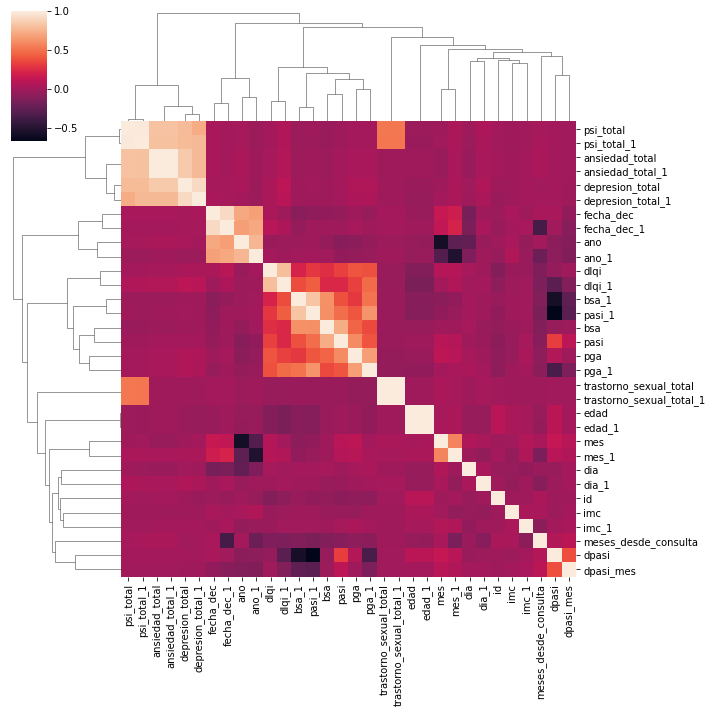

In [52]:
plt.figure(figsize=(20,20))
sns.clustermap(df5.dropna().corr())

In [26]:
df4.dropna().shape

(4097, 57)

In [27]:
df5.shape

(826, 57)

In [29]:
df4[df4["id"]==3499725][["id","ano","mes","dia","pasi_1","pasi","dpasi"]]

,id,ano,mes,dia,pasi_1,pasi,dpasi
0,3499725,2013,5,2,NaN,NaN,NaN
1,3499725,2013,7,29,NaN,NaN,NaN
2,3499725,2018,7,27,NaN,0.4,NaN
3,3499725,2018,10,24,0.4,0.4,0.0
4,3499725,2019,5,24,0.4,0.0,-0.4
5,3499725,2019,6,19,0.0,0.0,0.0
6,3499725,2019,7,9,0.0,0.0,0.0
7,3499725,2019,11,14,0.0,0.0,0.0
8,3499725,2019,12,9,0.0,0.2,0.2
9,3499725,2020,1,20,0.2,0.2,0.0


In [30]:
df5[df5["id"]==3499725][["id","ano","mes","dia","pasi_1","pasi","dpasi"]]

,id,ano,mes,dia,pasi_1,pasi,dpasi
9,3499725,2019,12,9,0.0,0.2,0.2


In [19]:
df2[df2["id"]==3499725][["id","ano","mes","dia","pasi"]]

,id,ano,mes,dia,pasi
14,3499725,2013,5,2,NaN
13,3499725,2013,7,29,NaN
12,3499725,2018,7,27,0.4
11,3499725,2018,10,24,NaN
10,3499725,2019,5,24,0.0
9,3499725,2019,6,19,NaN
8,3499725,2019,7,9,NaN
7,3499725,2019,11,14,NaN
6,3499725,2019,12,9,0.2
5,3499725,2020,1,20,NaN


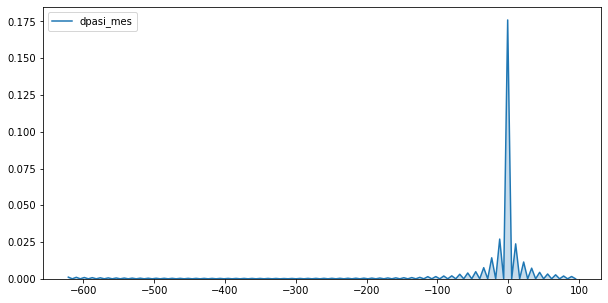

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,5))
sns.kdeplot(df5["dpasi_mes"], shade=True,ax = ax);

In [21]:
df5

,id,ano,mes,dia,sexo_paciente,imc,bsa,dlqi,pga,depresion_total,...,eritema_1,endurecimiento_1,descamacion_1,pasi_1,fecha_dec,fecha_dec_1,meses_desde_consulta,dpasi,dpasi_mes,pasi
9,3499725,2019,12,9,m,23.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,2020.024658,2019.955023,0.835616,0.2,0.239344,0.2
27,3499636,2019,3,8,m,24.8,6.0,0.0,0.0,0.0,...,2.0,0.0,1.0,5.7,2019.271918,2019.188584,1.000000,-4.4,-4.400000,1.3
29,3499636,2019,7,5,m,24.2,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.3,2019.597032,2019.438584,1.901370,-1.3,-0.683718,0.0
31,3499636,2019,10,30,m,26.6,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2019.915525,2019.672146,2.920548,0.0,0.000000,0.0
92,3493240,2019,9,18,f,33.3,7.0,1.0,2.0,0.0,...,2.0,2.0,2.0,7.6,2019.799315,2019.610731,2.263014,-4.0,-1.767554,3.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18303,522458,2020,3,9,m,30.0,4.0,17.0,2.0,0.0,...,2.0,2.0,1.0,2.2,2020.274658,2020.091553,2.197260,1.8,0.819202,4.0
18339,513721,2019,7,12,m,36.9,2.0,1.0,1.0,0.0,...,2.0,1.0,1.0,2.0,2019.616210,2019.357991,3.098630,-0.5,-0.161362,1.5
18341,513721,2019,12,4,m,34.0,1.0,0.0,1.0,0.0,...,1.0,1.0,1.0,1.5,2020.010959,2019.890868,1.441096,0.0,0.000000,1.5
18343,513721,2020,3,4,m,34.0,0.3,0.0,1.0,0.0,...,1.0,1.0,1.0,1.5,2020.260959,2020.110731,1.802740,-0.3,-0.166413,1.2


In [22]:
df4["dpasi_mes"].describe()

count    11919.000000
mean        -0.509430
std          9.890708
min       -620.500000
25%          0.000000
50%          0.000000
75%          0.000000
max        149.041667
Name: dpasi_mes, dtype: float64

In [58]:
dpasi_f0 = ('dpasi_mes ~ pasi_1 + imc_1 + bsa_1 + dlqi_1 + pga_1 + edad_1 + '
            'depresion_total_1 + ansiedad_total_1 + trastorno_sexual_total_1 + psi_total_1 + '
            'eritema_1 + endurecimiento_1 + descamacion_1 + '
            'medicamento_adalimumab + medicamento_certolizumab + medicamento_etanercept + '
            'medicamento_golimumab + medicamento_guselkumab + medicamento_infliximab + '
            'medicamento_ixekinumab + medicamento_secukinumab  + medicamento_ustekinumab + '
            'medicamento_adalimumab*pasi_1 + medicamento_certolizumab*pasi_1 + medicamento_etanercept*pasi_1 + '
            'medicamento_golimumab*pasi_1 + medicamento_guselkumab*pasi_1 + medicamento_infliximab*pasi_1 + '
            'medicamento_ixekinumab*pasi_1 + medicamento_secukinumab*pasi_1  + medicamento_ustekinumab*pasi_1' 
           )
model_f0 = smf.ols(formula = dpasi_f0, data = df4.dropna()).fit()
model_f0.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              dpasi_mes   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     2.688
Date:                Thu, 23 Jul 2020   Prob (F-statistic):           2.02e-08
Time:                        21:34:20   Log-Likelihood:                -16041.
No. Observations:                4097   AIC:                         3.217e+04
Df Residuals:                    4053   BIC:                         3.245e+04
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                  0.4093      0.963      0.425      0.671      -1.479       2.297
eritema_1[T.1.0]                          -0.6619      0.789     -0.839      0.401      -2.208       0.884
eritema_1[T.2.0]                          -0.4245      0.979     -0.433      0.665      -2.344       1.495
eritema_1[T.3.0]                           0.8469      1.194      0.709      0.478      -1.495       3.188
eritema_1[T.4.0]                           1.4594      1.594      0.916      0.360      -1.666       4.585
eritema_1[T.5.0]                           1.0979      3.616      0.304      0.761      -5.992       8.188
endurecimiento_1[T.1.0]                    2.3132      0.794      2.913      0.004       0.756       3.870
endurecimiento_1[T.2.0]                    3.6481      1.045      3.489      0.000       1.598       5.698
endurecimiento_1[T.3.0]                    5.1546      1.328      3.881      0.000       2.550       7.759
endurecimiento_1[T.4.0]                    3.7236      1.716      2.170      0.030       0.360       7.087
endurecimiento_1[T.5.0]                    4.7128      4.151      1.135      0.256      -3.426      12.852
descamacion_1[T.1.0]                      -0.5174      0.833     -0.621      0.535      -2.151       1.116
descamacion_1[T.2.0]                      -1.8181      1.079     -1.685      0.092      -3.934       0.297
descamacion_1[T.3.0]                      -3.1870      1.353     -2.355      0.019      -5.840      -0.534
descamacion_1[T.4.0]                      -2.1876      1.810     -1.208      0.227      -5.737       1.361
descamacion_1[T.5.0]                       1.5211      4.525      0.336      0.737      -7.351      10.393
medicamento_adalimumab[T.1.0]             -0.8206      0.724     -1.134      0.257      -2.240       0.598
medicamento_certolizumab[T.1.0]            0.3802      4.889      0.078      0.938      -9.205       9.966
medicamento_etanercept[T.1.0]             -0.2695      1.022     -0.264      0.792      -2.273       1.734
medicamento_golimumab[T.1.0]               0.2661      5.462      0.049      0.961     -10.443      10.975
medicamento_guselkumab[T.1.0]            -10.9046      3.819     -2.855      0.004     -18.392      -3.417
medicamento_infliximab[T.1.0]             -0.5266      4.343     -0.121      0.903      -9.041       7.987
medicamento_ixekinumab[T.1.0]             -0.8193      1.105     -0.742      0.458      -2.985       1.347
medicamento_secukinumab[T.1.0]            -0.4241      0.841     -0.505      0.614      -2.072       1.224
medicamento_ustekinumab[T.1.0]            -0.7545      0.752     -1.004      0.315      -2.228       0.719
pasi_1                                    -0.4194      0.078     -5.380      0.000     

In [57]:

dpasi_f1 = ('dpasi_mes ~ pasi_1 + imc_1 + bsa_1 + dlqi_1 + pga_1 + edad_1 + '
            'depresion_total_1 + ansiedad_total_1 + trastorno_sexual_total_1 + psi_total_1 + '
            'eritema_1 + endurecimiento_1 + descamacion_1 + '
            'medicamento_adalimumab + medicamento_certolizumab + medicamento_etanercept + '
            'medicamento_golimumab + medicamento_guselkumab + medicamento_infliximab + '
            'medicamento_ixekinumab + medicamento_secukinumab  + medicamento_ustekinumab + '
            'medicamento_adalimumab*pasi_1 + medicamento_certolizumab*pasi_1 + medicamento_etanercept*pasi_1 + '
            'medicamento_golimumab*pasi_1 + medicamento_guselkumab*pasi_1 + medicamento_infliximab*pasi_1 + '
            'medicamento_ixekinumab*pasi_1 + medicamento_secukinumab*pasi_1  + medicamento_ustekinumab*pasi_1' 
           )
model_f1 = smf.ols(formula = dpasi_f1, data = df5.dropna()).fit()
model_f1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              dpasi_mes   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     2.672
Date:                Thu, 23 Jul 2020   Prob (F-statistic):           1.17e-07
Time:                        21:34:03   Log-Likelihood:                -3848.6
No. Observations:                 826   AIC:                             7783.
Df Residuals:                     783   BIC:                             7986.
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                  2.0046      4.779      0.419      0.675      -7.376      11.386
eritema_1[T.1.0]                          -2.4102      4.019     -0.600      0.549     -10.299       5.479
eritema_1[T.2.0]                           0.0910      5.031      0.018      0.986      -9.785       9.967
eritema_1[T.3.0]                           7.1185      6.330      1.125      0.261      -5.307      19.544
eritema_1[T.4.0]                          14.4496      8.558      1.688      0.092      -2.350      31.249
eritema_1[T.5.0]                          21.0328     13.906      1.512      0.131      -6.266      48.331
endurecimiento_1[T.1.0]                   10.5039      3.628      2.895      0.004       3.383      17.625
endurecimiento_1[T.2.0]                   18.6388      5.065      3.680      0.000       8.696      28.582
endurecimiento_1[T.3.0]                   24.8529      6.628      3.749      0.000      11.841      37.865
endurecimiento_1[T.4.0]                   21.0173      8.997      2.336      0.020       3.356      38.678
endurecimiento_1[T.5.0]                   23.7886     17.200      1.383      0.167      -9.976      57.553
descamacion_1[T.1.0]                       1.7049      4.094      0.416      0.677      -6.332       9.741
descamacion_1[T.2.0]                      -3.0638      5.520     -0.555      0.579     -13.899       7.771
descamacion_1[T.3.0]                     -11.2369      6.962     -1.614      0.107     -24.903       2.430
descamacion_1[T.4.0]                      -2.6499      9.195     -0.288      0.773     -20.700      15.400
descamacion_1[T.5.0]                       4.1344     19.999      0.207      0.836     -35.124      43.393
medicamento_adalimumab[T.1.0]             -3.4948      3.575     -0.977      0.329     -10.513       3.524
medicamento_certolizumab[T.1.0]           -0.0998     26.385     -0.004      0.997     -51.894      51.695
medicamento_etanercept[T.1.0]              0.2757      4.937      0.056      0.955      -9.416       9.967
medicamento_golimumab[T.1.0]              -1.6310     19.831     -0.082      0.934     -40.559      37.297
medicamento_guselkumab[T.1.0]            -78.1187     34.685     -2.252      0.025    -146.206     -10.031
medicamento_infliximab[T.1.0]             -1.5896     18.726     -0.085      0.932     -38.349      35.170
medicamento_ixekinumab[T.1.0]             -1.6070      5.358     -0.300      0.764     -12.124       8.910
medicamento_secukinumab[T.1.0]            -1.8410      3.843     -0.479      0.632      -9.386       5.704
medicamento_ustekinumab[T.1.0]            -2.0513      3.641     -0.563      0.573      -9.199       5.096
pasi_1                                    -1.4555      0.364     -3.998      0.000     

In [63]:

dpasi_f2 = ('dpasi_mes ~ pasi_1 + imc_1 + bsa_1 + dlqi_1 + pga_1 + edad_1 + '
            'depresion_total_1 + ansiedad_total_1 + trastorno_sexual_total_1 + psi_total_1 + '
            'eritema_1 + endurecimiento_1 + descamacion_1 + '
            'medicamento_adalimumab + medicamento_certolizumab + medicamento_etanercept + '
            'medicamento_golimumab + medicamento_guselkumab + medicamento_infliximab + '
            'medicamento_ixekinumab + medicamento_secukinumab  + medicamento_ustekinumab'
            )
model_f2 = smf.ols(formula = dpasi_f2, data = df5.dropna()).fit()
model_f2.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              dpasi_mes   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     3.153
Date:                Thu, 23 Jul 2020   Prob (F-statistic):           8.47e-09
Time:                        22:14:20   Log-Likelihood:                -3851.4
No. Observations:                 826   AIC:                             7773.
Df Residuals:                     791   BIC:                             7938.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           0.7761      4.638      0.167      0.867      -8.328       9.880
eritema_1[T.1.0]                   -2.3149      4.006     -0.578      0.564     -10.178       5.549
eritema_1[T.2.0]                    0.1706      5.003      0.034      0.973      -9.649       9.990
eritema_1[T.3.0]                    7.0437      6.298      1.118      0.264      -5.320      19.407
eritema_1[T.4.0]                   16.0729      8.478      1.896      0.058      -0.569      32.715
eritema_1[T.5.0]                   25.1901     13.303      1.894      0.059      -0.923      51.303
endurecimiento_1[T.1.0]            10.7686      3.616      2.978      0.003       3.671      17.866
endurecimiento_1[T.2.0]            19.0417      5.044      3.775      0.000       9.140      28.944
endurecimiento_1[T.3.0]            24.5099      6.561      3.736      0.000      11.631      37.389
endurecimiento_1[T.4.0]            20.8065      8.937      2.328      0.020       3.264      38.349
endurecimiento_1[T.5.0]            27.5552     17.003      1.621      0.105      -5.820      60.931
descamacion_1[T.1.0]                2.0888      4.065      0.514      0.608      -5.891      10.069
descamacion_1[T.2.0]               -2.6460      5.467     -0.484      0.629     -13.378       8.086
descamacion_1[T.3.0]               -9.8643      6.879     -1.434      0.152     -23.367       3.638
descamacion_1[T.4.0]               -1.3811      9.120     -0.151      0.880     -19.284      16.522
descamacion_1[T.5.0]                0.3121     19.730      0.016      0.987     -38.418      39.042
medicamento_adalimumab[T.1.0]      -2.3452      3.112     -0.754      0.451      -8.455       3.764
medicamento_certolizumab[T.1.0]    -7.2045     15.408     -0.468      0.640     -37.449      23.040
medicamento_etanercept[T.1.0]       0.7512      4.050      0.185      0.853      -7.199       8.701
medicamento_golimumab[T.1.0]       -3.7339     15.296     -0.244      0.807     -33.760      26.293
medicamento_guselkumab[T.1.0]     -33.6809     15.310     -2.200      0.028     -63.734      -3.628
medicamento_infliximab[T.1.0]      -0.3757     18.673     -0.020      0.984     -37.029      36.278
medicamento_ixekinumab[T.1.0]       2.5123      4.645      0.541      0.589      -6.606      11.631
medicamento_secukinumab[T.1.0]      0.0955      3.042      0.031      0.975      -5.875       6.066
medicamento_ustekinumab[T.1.0]     -0.0633      3.147     -0.020      0.984      -6.241       6.114
pasi_1                             -1.2366      0.332     -3.726      0.000      -1.888      -0.585
imc_1                               0.0506      0.061      0.833      0.405      -0.069       0.170
bsa_1                              -0.2196      0.143     -1.532      0.126      -0

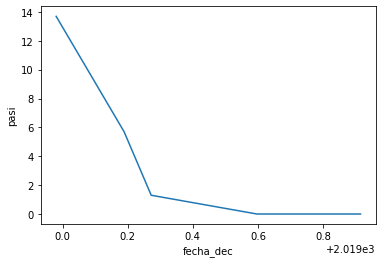

In [74]:
sns.lineplot(x = "fecha_dec",
             y = "pasi",
             data = df5[df5["id"]==ids[2]])

In [64]:
df5

,id,ano,mes,dia,sexo_paciente,imc,bsa,dlqi,pga,depresion_total,...,eritema_1,endurecimiento_1,descamacion_1,pasi_1,fecha_dec,fecha_dec_1,meses_desde_consulta,dpasi,dpasi_mes,pasi
0,20946751,2018,12,13,f,26.7,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2019.035616,NaN,NaN,NaN,NaN,0.0
1,3499725,2013,5,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2013.422146,NaN,NaN,NaN,NaN,NaN
2,3499725,2013,7,29,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2013.662785,2013.422146,2.887671,NaN,NaN,NaN
3,3499725,2018,7,27,m,23.2,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2018.657306,2013.662785,59.934247,NaN,NaN,0.4
4,3499725,2018,10,24,m,23.2,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,0.4,2018.899087,2018.657306,2.901370,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18403,501389,2020,2,28,f,24.6,NaN,9.0,NaN,0.0,...,NaN,NaN,NaN,2.7,2020.243379,2020.105251,1.657534,0.0,0.0,NaN
18404,501053,2019,3,4,f,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2019.260959,NaN,NaN,NaN,NaN,0.0
18405,501053,2019,11,14,f,21.3,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,0.0,2019.955023,2019.260959,8.328767,0.0,0.0,0.0
18406,501053,2020,2,12,f,21.3,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,0.0,2020.199543,2019.955023,2.934247,0.0,0.0,NaN
